In [4]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы A, B, C, D отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['A', 'B', 'C', 'D'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [225]:
def find_period_length_fft(data: np.ndarray, **kwargs) -> float:
    """Вычисление длины периода в заданном веторе данных.

    Args:
        data (np.ndarray): Вектор данных.
        **kwargs: Дополнительные ключевые аргументы - параметры для метода Фурье.
                Подробнее можно прочитать на https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy-fft-fft

    Returns:
        float: Значение периода. Может получиться дробным.
    """

    # Применение прямого преобразования метода Фурье к данным
    yf = scipy.fft.fft(data, **kwargs)
    # Поиск индекса максимального значения в абсолютных величинах преобразованного вектора
    idx = np.argmax(np.abs(yf))
    # Нахождение длины периода, путем деления длины исходных данных на индекс максимального значения
    period = len(data)/idx
    
    return period

In [236]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 

        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

Получить спектр дробной части бетатронной частоты

2 в степени n то ли база, то ли опора. Должна быть степенью двойки

0.5 - частота найквеста. От нее все отражается 

In [250]:
def get_spectrum(coordinate_vector, number_of_samples=2**8, offset=3, is_left_part=True): # Рассчитывает спектр и амплитуды ДОПИСАТЬ, ЧТОБЫ ВОЗВРАЩАЛА СПЕКТР
    fourier_transformed_vector = scipy.fft.fft(np.array(coordinate_vector)[:number_of_samples]) / data_length #Просто нормировка

    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[3: number_of_samples // 2]])

    amplitudes = np.abs(sliced_fourier_transformed_vector)

    if is_left_part:
        # frequences = np.linspace(0, 0.5, data_length // 2)
        frequences = np.arange(0, 0.5, 1 / data_length)
    else:
        amplitudes = 1 - amplitudes
        frequences = np.arange(0.5, 1, 1 / data_length) + 1 / data_length

    return frequences, amplitudes

In [233]:
def find_main_frequence(frequences, amplitudes, slice_percentage=1): # ДОБАВИТЬ ЕЩЕ АМПЛИТУДЫ НА ВХОД, И ВЫДАТЬ ЧАСТОТУ ОСНОВНУЮ
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [177]:
def correct_tune(coordinate_vector, Q_0, number_of_periods, delta_Q, data_length=256):
    Q_p = Q_0 + delta_Q * (2*np.arange(data_length)/data_length - 1)
    return Q_p

In [10]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

In [20]:
data = read_data(r'bpm_data/11_01_booster_libera08_hbpm3_1_full', offset=offset, data_length=len_data)
data

,A,B,C,D
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


In [193]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['A'] + data['C']
summary_resonance['Y'] = data['B'] + data['D']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['A'] - data['C']
difference_resonance['Y'] = data['B'] - data['D']

In [191]:
period = find_period_length_fft(summary_resonance['X'])
period

2126.9290060851927

In [195]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33

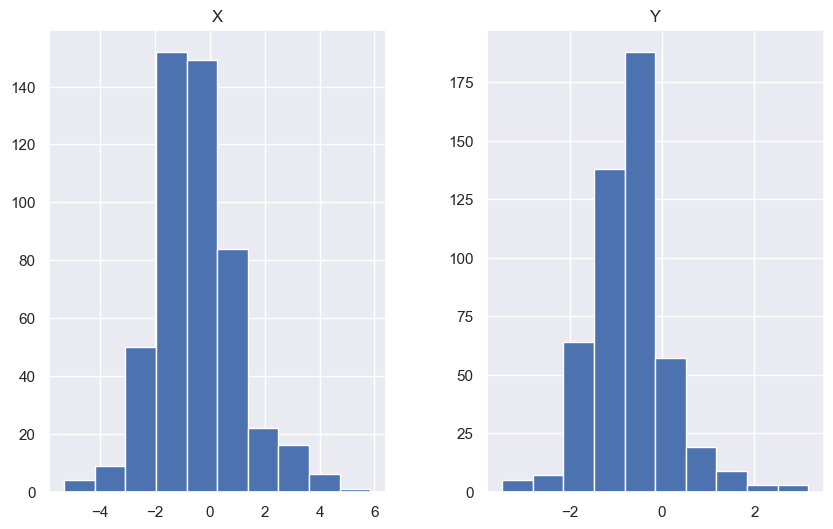

In [237]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords.hist(figsize = (10, 6));

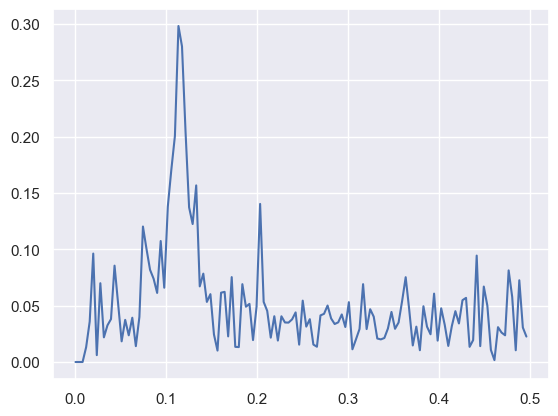

In [247]:
amp, freq = get_spectrum(beam_center_coords['X'])
plt.plot(amp, freq)

In [248]:
find_main_frequence(amp, freq)

0.11328125

In [230]:
frequences = pd.DataFrame()
frequences['smth'] = np.arange(0, 256//2) / 256
frequences = frequences.set_index('smth')
main_frequence = {}

for axis in 'XY':
    frequences[axis] = get_frequences(gravity_center_coords[axis])
    main_frequence[axis] = find_main_frequence_index(frequences[axis], normed=True)

In [234]:
print(main_frequence)

{'X': 0.11328125, 'Y': 0.203125}


По иксу отложена дробная часть бетатронной частоты. По игреку - амплитуда в условных единицах

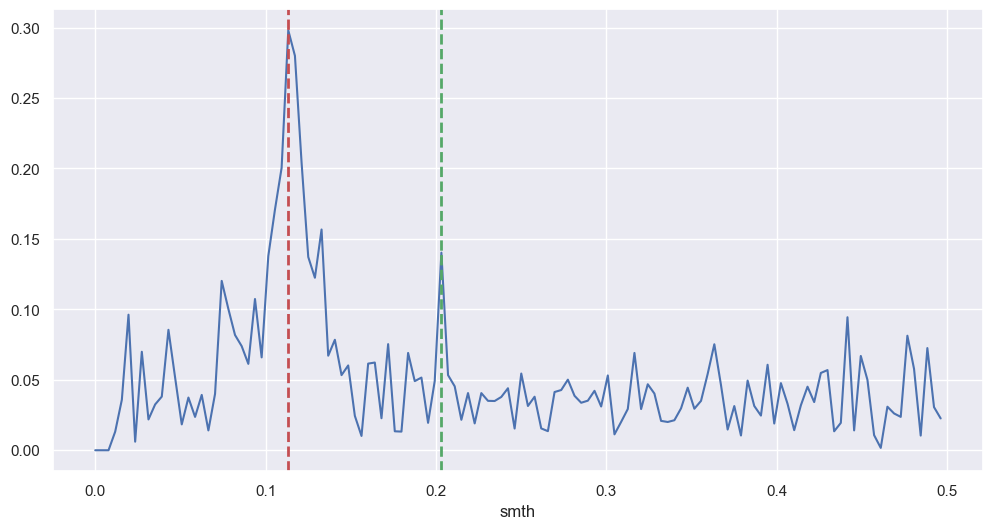

In [231]:
frequences['X'].plot(figsize=(12, 6))
plt.axvline(main_frequence['X'], ls='--', color='r', lw=2)
plt.axvline(main_frequence['Y'], ls='--', color='g', lw=2)

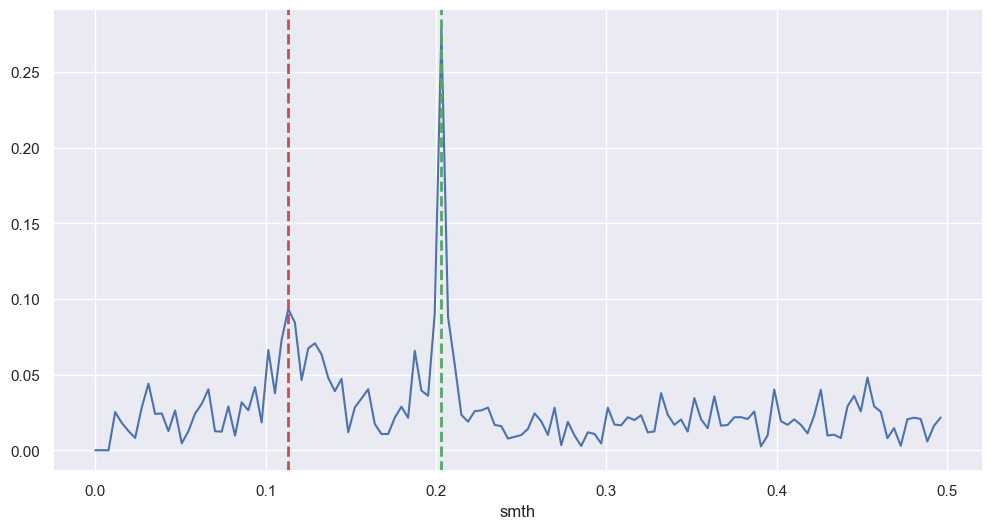

In [228]:
frequences['Y'].plot(figsize=(12, 6))
plt.axvline(main_frequence['X'], ls='--', color='r', lw=2)
plt.axvline(main_frequence['Y'], ls='--', color='g', lw=2)

In [ ]:
def CorrectTune(coordinate_vector, Q_0, N_p, delta_Q):
    
    N_t = 256
    Q_p = []
    A_p = []
    csi = []
 
    for i in range(N_p+1):
        Q_p[i] = Q_0 + delta_Q * ((2 * i - N_p) / N_p)
    return Q_p[i]

        for k in range(N_t):
            A_p[i] = x[k] * np.exp(2 * i * np.pi * Q_p[i] * k)
    
    p = np.argmax(A_p[:N_p+1])

    for p1 in range(0, p+1, -1):
        if np.abs(A_p[p1]) < 0.5 * np.abs(A_p[p]):
            p_1 = p1
            break

    for p2 in range(p, N_p):
        if np.abs(A_p[p2]) < 0.5 * np.abs(A_p[p]):
            p_2 = p2
            break

    for n in range(p_1, p_2+1):
        csi[n] = n - 0.5 * (p_1 + p_2)

    M4, M2, Y2, Y1, Y = 0, 0, 0, 0, 0

    for k in range(p_1, p_2+1):
        M4 += csi[k]**2
        M2 += csi[k]**2
        Y2 += csi[k]**2 * np.abs(A_p[k])
        Y1 += csi[k]* np.abs(A_p[k])
        Y += np.abs(A_p[k])

    p_opt = (p_1 + p_2) / 2 - Y1 / (2 * M2) * (M2**2 - M4 * (p_2 - p_1 + 1)) / (M2 * Y - (p_2 - p_1 +1 ) * Y2)

    Q = Q_0 * delta_Q * (2 * p_opt - N_p) / N_p

    a = (M2 * Y - (p_2 - p_1 + 1) * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))

    b = Y1 / M2

    c = - (M4 * Y - M2 * Y2) / (M2**2 - M4 * (p_2 - p_1 + 1))